In [1]:
'''
A. Data Engineering
'''

'''
1. Import Naver Movie Review Raw Dataset from Github
'''
! git clone https://github.com/simonjisu/nsmc_study.git

from IPython.display import clear_output 
clear_output()

In [2]:
'''
2. Import Libraries for Data Engineering
'''
import re
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import unicodedata

print("Tensorflow version {}".format(tf.__version__))
import random
SEED = 1234
tf.random.set_seed(SEED)
AUTO = tf.data.experimental.AUTOTUNE

Tensorflow version 2.9.2


In [3]:
'''
T. TPU Initialization
'''
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU {}'.format(tpu.cluster_spec().as_dict()['worker']))
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: {}".format(strategy.num_replicas_in_sync))

Running on TPU ['10.84.12.34:8470']


REPLICAS: 8


In [4]:
'''
3. Tokenizer Install & import
''' 
# Keras Tokenizer is a tokenizer provided by default in tensorflow 2.X and is a word level tokenizer. It does not require a separate installation.

'\n3. Tokenizer Install & import\n'

In [5]:
'''
4. Load and modifiy to pandas dataframe
'''
import pandas as pd

pd.set_option('display.max_colwidth', 100)
# pd.set_option('display.max_colwidth', None)

train = pd.read_csv("/content/nsmc_study/data/ratings_train.txt", sep='\t')
test = pd.read_csv("/content/nsmc_study/data/ratings_test.txt", sep='\t')

train = train.drop(columns=['id'])
test = test.drop(columns=['id'])

print(train.shape)
print(test.shape)

train_data = train.dropna() #말뭉치에서 nan 값을 제거함
test_data  = test.dropna()

(150000, 2)
(50000, 2)


In [6]:
'''
5. Preprocess and build list
'''

def preprocess_func(sentence):
    # 구두점에 대해서 띄어쓰기
    # ex) 12시 땡! -> 12시 땡 !
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    sentence = sentence.strip()
    return sentence

train_data['document'] = train_data['document'].apply(preprocess_func)
test_data['document']  = test_data['document'].apply(preprocess_func)

<ipython-input-6-20cc94849af6>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['document'] = train_data['document'].apply(preprocess_func)
<ipython-input-6-20cc94849af6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['document']  = test_data['document'].apply(preprocess_func)


In [7]:
'''
6. Tokenizer and Vocab define
'''

train_data['label'] = train_data['label'].astype(int)
Label_Train = train_data["label"].to_numpy()

test_data['label'] = test_data['label'].astype(int)
Label_test = test_data["label"].to_numpy()

src_train_df = train_data['document']
src_test_df  = test_data['document']

print(src_train_df[:10])

train_sentence  = src_train_df.apply(lambda x: "<SOS> " + str(x))
test_sentence  = src_test_df.apply(lambda x: "<SOS> " + str(x))

filters = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n'
oov_token = '<unk>'

# Define tokenizer
SRC_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters = filters, oov_token=oov_token)

SRC_tokenizer.fit_on_texts(train_sentence)

vocab_size = len(SRC_tokenizer.word_index) + 1

print('Encoder 단어 집합의 크기 :',vocab_size)

<ipython-input-7-82568d280f6d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['label'] = train_data['label'].astype(int)
<ipython-input-7-82568d280f6d>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['label'] = test_data['label'].astype(int)


0                                                                             아 더빙 .  .  진짜 짜증나네요 목소리
1                                                     흠 .  .  . 포스터보고 초딩영화줄 .  .  .  . 오버연기조차 가볍지 않구나
2                                                                                   너무재밓었다그래서보는것을추천한다
3                                                               교도소 이야기구먼  .  . 솔직히 재미는 없다 .  . 평점 조정
4                                     사이몬페그의 익살스런 연기가 돋보였던 영화 ! 스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다
5                                              막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화 . ㅋㅋㅋ .  .  . 별반개도 아까움 .
6                                                                              원작의 긴장감을 제대로 살려내지못했다 .
7    별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지 .  . 정말 발로해도 그것보단 낫겟다 납치 . 감금만반복반복 .  . 이드라마는 가족도없다 연기못하는사람만모엿네
8                                                                              액션이 없는데도 재미 있는 몇안되는 영화
9                                                왜케 평점이 낮은건데 ?  꽤 볼만한데 .  .  헐리우드식

In [8]:
'''
7. Tokenizer test
'''
lines = [
  "게임 하고 싶은데 할래?",
  "나 너 좋아하는 것 같아",
  "딥 러닝 자연어 처리를 잘 하고 싶어"
]
for line in lines:
    txt_2_ids = SRC_tokenizer.texts_to_sequences([line])
    ids_2_txt = SRC_tokenizer.sequences_to_texts(txt_2_ids)
    print("Input     :", line)
    print("txt_2_ids :", txt_2_ids)
    print("ids_2_txt :", ids_2_txt[0],"\n")

Input     : 게임 하고 싶은데 할래?
txt_2_ids : [[2492, 95, 1214, 12968]]
ids_2_txt : 게임 하고 싶은데 할래 

Input     : 나 너 좋아하는 것 같아
txt_2_ids : [[244, 1360, 197, 52, 956]]
ids_2_txt : 나 너 좋아하는 것 같아 

Input     : 딥 러닝 자연어 처리를 잘 하고 싶어
txt_2_ids : [[286077, 7701, 1, 26800, 15, 95, 2358]]
ids_2_txt : 딥 러닝 <unk> 처리를 잘 하고 싶어 



In [9]:
'''
8. Tokenize  
''' 
# 토큰화 / 정수 인코딩 / 시작 토큰과 종료 토큰 추가 / 패딩
Train_tkn_inputs = SRC_tokenizer.texts_to_sequences(train_sentence)
Test_tkn_inputs  = SRC_tokenizer.texts_to_sequences(test_sentence)

Maximum length of review : 60
Average length of review : 8.846214873829128


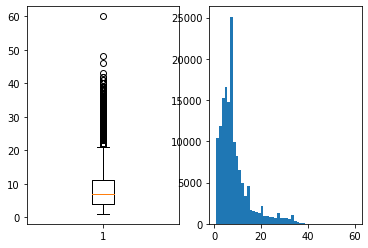

In [10]:
'''
9. Explore the tokenized datasets.
'''
len_result = [len(s) for s in Train_tkn_inputs]

print('Maximum length of review : {}'.format(np.max(len_result)))
print('Average length of review : {}'.format(np.mean(len_result)))

plt.subplot(1,2,1)
plt.boxplot(len_result)
plt.subplot(1,2,2)
plt.hist(len_result, bins=50)
plt.show()

In [11]:
'''
10. Pad sequences
'''

from tensorflow.keras.preprocessing.sequence import pad_sequences
max_len = 50
padded_train_tkn = pad_sequences(Train_tkn_inputs,  maxlen=max_len, padding='post', truncating='post')
padded_test_tkn = pad_sequences(Test_tkn_inputs,  maxlen=max_len, padding='post', truncating='post')

In [12]:
'''
11. Data type define
'''
padded_train_tkn = tf.cast(padded_train_tkn, dtype=tf.int64)
padded_test_tkn = tf.cast(padded_test_tkn, dtype=tf.int64)

In [13]:
'''
12. Split Data
'''
print('질문 데이터의 크기(shape) :', padded_train_tkn.shape)

# 0번째 샘플을 임의로 출력
print(padded_train_tkn[0])

X_train = padded_train_tkn[:125000]
y_train = Label_Train[:125000]
X_valid = padded_train_tkn[125000:]
y_valid = Label_Train[125000:]
X_test  = padded_test_tkn
y_test  = Label_test

print('Number of minibatch for training dataset   : {}'.format(len(X_train)))
print('Number of minibatch for validation dataset : {}'.format(len(X_valid)))
print('Number of minibatch for testing dataset    : {}'.format(len(X_test)))

질문 데이터의 크기(shape) : (149995, 50)
tf.Tensor(
[   2   25  937    6 6725 1097    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0], shape=(50,), dtype=int64)
Number of minibatch for training dataset   : 125000
Number of minibatch for validation dataset : 24995
Number of minibatch for testing dataset    : 49997


In [14]:
'''
B. Model Engineering
'''

'''
M1. Import Libraries for Model Engineering
'''
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.models import load_model

In [15]:
'''
M2. Set Hyperparameters
'''
embedding_dim = 256
hidden_units = 128
EPOCHS = 20
learning_rate = 5e-4

In [16]:
from tensorflow import keras
from tensorflow.keras import layers

# initialize and compile model within strategy scope
with strategy.scope():
    '''
    M3. Build NN model
    '''
    # Input for variable-length sequences of integers
    inputs = keras.Input(shape=(None,), dtype="int32")
    # Embed each integer in a embedding_dim-dimensional vector
    x = layers.Embedding(vocab_size, embedding_dim)(inputs)
    # Add 2 bidirectional LSTMs
    x = layers.Bidirectional(layers.LSTM(hidden_units, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(hidden_units))(x)
    # Add a classifier
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    '''
    M4. Optimizer
    '''
    optimizer = optimizers.Adam(learning_rate=learning_rate)

    '''
    M5. Model Compilation - model.compile
    '''
    # model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    model.compile(optimizer=optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 256)         75927552  
                                                                 
 bidirectional (Bidirectiona  (None, None, 256)        394240    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 76,716,289
Trainable params: 76,716,289
Non-tra

In [17]:
'''
M6. EarlyStopping
'''
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 8)

In [18]:
'''
M7. ModelCheckpoint
'''
mc = ModelCheckpoint('best_model.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)

In [19]:
'''
M8. Train and Validation - `model.fit`
'''
history = model.fit(X_train, y_train, epochs = EPOCHS, validation_data = (X_valid, y_valid), callbacks=[es, mc])

Epoch 1/20
3907/3907 [==============================] - ETA: 0s - loss: 0.4185 - accuracy: 0.7957
Epoch 1: val_accuracy improved from -inf to 0.83181, saving model to best_model.h5
3907/3907 [==============================] - 221s 53ms/step - loss: 0.4185 - accuracy: 0.7957 - val_loss: 0.3639 - val_accuracy: 0.8318
Epoch 2/20
3907/3907 [==============================] - ETA: 0s - loss: 0.1403 - accuracy: 0.9493
Epoch 2: val_accuracy did not improve from 0.83181
3907/3907 [==============================] - 193s 49ms/step - loss: 0.1403 - accuracy: 0.9493 - val_loss: 0.4274 - val_accuracy: 0.8166
Epoch 3/20
3906/3907 [============================>.] - ETA: 0s - loss: 0.0596 - accuracy: 0.9804
Epoch 3: val_accuracy did not improve from 0.83181
3907/3907 [==============================] - 194s 50ms/step - loss: 0.0596 - accuracy: 0.9804 - val_loss: 0.5456 - val_accuracy: 0.8149
Epoch 4/20
3906/3907 [============================>.] - ETA: 0s - loss: 0.0331 - accuracy: 0.9889
Epoch 4: val_ac

In [20]:
'''
M9. Assess model performance
'''
loaded_model = load_model('best_model.h5')
print("\n Test Accuracy: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1563/1563 [==============================] - 56s 34ms/step - loss: 0.3696 - accuracy: 0.8290

 Test Accuracy: 0.8290


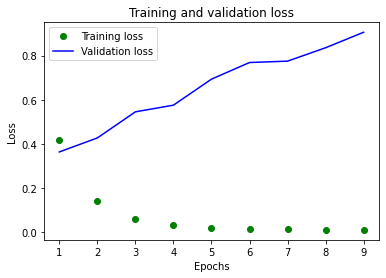

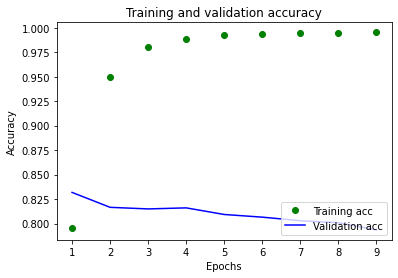

In [21]:
'''
M10. [Opt] Plot Loss and Accuracy
'''
history_dict = history.history
history_dict.keys()

acc      = history_dict['accuracy']
val_acc  = history_dict['val_accuracy']
loss     = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'o', color='g', label='Training loss')   # 'bo'
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


plt.plot(epochs, acc, 'o', color='g', label='Training acc')   # 'bo'
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [22]:
'''
M11. [Opt] Training result test for Code Engineering
'''
def sentiment_predict(new_sentence):
    # 알파벳과 숫자를 제외하고 모두 제거 및 알파벳 소문자화
    new_sentence = preprocess_func(new_sentence)

    txt_2_ids = SRC_tokenizer.texts_to_sequences([new_sentence])

    pad_sequence = pad_sequences(txt_2_ids, maxlen=max_len) # 패딩
    score = float(loaded_model.predict(pad_sequence)) # 예측

    if(score > 0.5):
        print("A positive review with a {:.2f}% chance. ".format(score * 100))
    else:
        print("A negative review with a {:.2f}% chance. ".format((1 - score) * 100))

for idx in range(10):
    print('----'*30)
    test_input = test_sentence[20000+idx]
    print("Test sentence from datasets:\n", test_input)
    sentiment_predict(test_input)
    if(y_test[20000+idx] > 0.5):
        print("Ground truth is positive!")
    else:
        print("Ground truth is negative!")

------------------------------------------------------------------------------------------------------------------------
Test sentence from datasets:
 <SOS> 스토커여자 대단하다는 생각이든다 ㅋㅋ
1/1 [==============================] - 2s 2s/step
A positive review with a 60.75% chance. 
Ground truth is positive!
------------------------------------------------------------------------------------------------------------------------
Test sentence from datasets:
 <SOS> 진심너무재미없엇던영화1 . 2편은그나마갠찮은디이건머 .  .  .
1/1 [==============================] - 0s 40ms/step
A positive review with a 65.04% chance. 
Ground truth is positive!
------------------------------------------------------------------------------------------------------------------------
Test sentence from datasets:
 <SOS> 너무 재밋엇는데 .  .  .  어디서 다운받지 ㅠㅠdvd라도 소장하고싶삼
1/1 [==============================] - 0s 34ms/step
A positive review with a 64.29% chance. 
Ground truth is negative!
--------------------------------------------------------------------------